# [IAPR][iapr]: Lab 1 ‒  Image segmentation



## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os

os.pardir = '/Users/berkay/OneDrive/EPFL_COURSES/EE451/LABS/iapr'
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by
Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* An additional method of your choice (5 pts)

Each section should display the resulting segmentation as well as the size in pixel of the detected region. Comment
each method limitations and/or advantages.

### 1.1 Brain image visualization

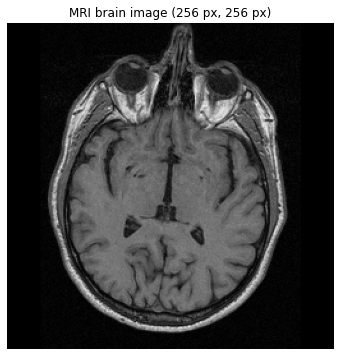

In [3]:
import skimage.io, skimage.filters, skimage.exposure, skimage.color
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.signal


%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing (5pts)

For this part, the aim is to recursively iterate through neighbour pixels of a pixel and cluster pixels that have similar pixel values in a region until all the pixels included in the region have no neighbour pixels that are similar to themselves.

In [4]:
class utils():
    
    
    # filters
    LAPLACIAN_FILTER = np.array([[0, -1, 0],
                                [-1, 5, -1],
                                [0, -1, 0]])
    
    HIGH_PASS_FILTER = np.array([[-2, -1, -2],
                                 [-1, +16, -1],
                                 [-2, -1, -2]])

    def __init__(self, name):
      self.name = name
     
        
    def draw_hist(self, imgs, titles):
        """
        draws images and their corresponding histograms
        """
        num_images = len(imgs)
        plt.figure()
        _, ax = plt.subplots(num_images, 2, figsize=(16, num_images * 6))
        for i in range(num_images):
            ax[i][0].imshow(imgs[i], cmap='gray')
            ax[i][1].hist(imgs[i].ravel(), bins=256)
            ax[i][0].set_title(titles[i])
            ax[i][1].set_title(titles[i] + ' Histogram')
            ax[i][0].set_xlabel('x')
            ax[i][1].set_ylabel('y')
            ax[i][1].set_xlabel('Pixel Value')
            ax[i][1].set_ylabel('Number of Pixels')
        plt.show()
    


Region growing algorithm is sensitive to the noise and sharpness of the image. Besides, for a successful segmentation with region growing, the region should have boundries that through which the region cannot expand with the givent threshold.

To have better results with region growing, severel pre-processing techniques are applied to the image, includin, sharpening, denoising, histogram equalization etc.

/Users/berkay/opt/miniconda3/lib/python3.8/site-packages/skimage/util/dtype.py:482: UserWarning: Downcasting int64 to uint16 without scaling because max value 1703 fits in uint16
  return _convert(image, np.uint16, force_copy)


<Figure size 432x288 with 0 Axes>

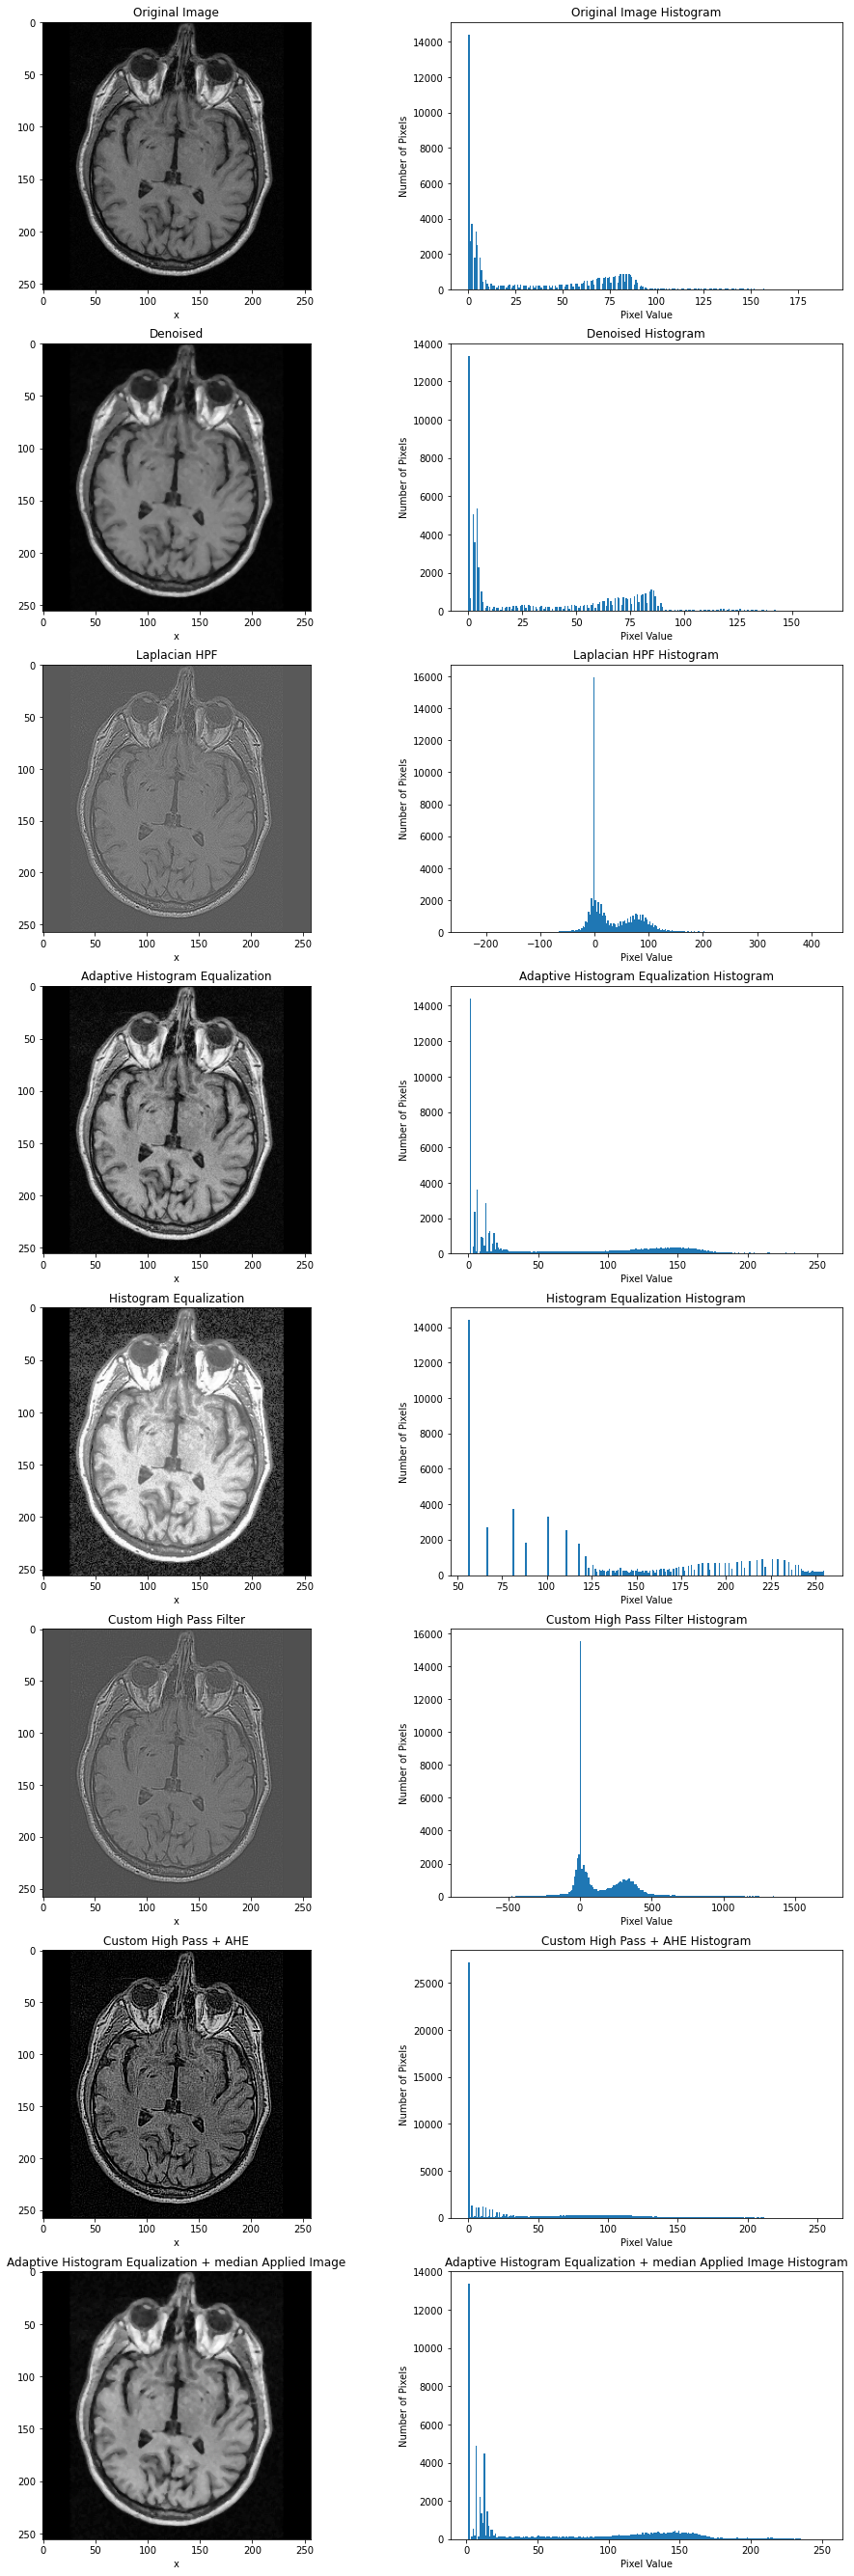

In [5]:
# denoised image
denoised_img = skimage.filters.median(brain_im)

# Laplacian HPF applied image
laplacian_filtered_img = scipy.signal.convolve2d(brain_im, utils.LAPLACIAN_FILTER)

# Adaptive Histogram Equalization Applied Image
adapt_hist_img = 255 * skimage.exposure.equalize_adapthist(brain_im)

# Histogram Equalization Applied Image
eq_hist_img = 255 * skimage.exposure.equalize_hist(brain_im)

# Custom HPF Applied Image
sharpened_img = scipy.signal.convolve2d(brain_im, utils.HIGH_PASS_FILTER)

# Custom HPF + Adaptive Histogram Equalization Applied Image
sharpened_adapt_hist = 255 * skimage.exposure.equalize_adapthist(sharpened_img)

# Adaptive Histogram Equalization + median Applied Image
adapt_hist_median_img = skimage.filters.median(adapt_hist_img)



titles = ('Original Image', 'Denoised', 'Laplacian HPF', 'Adaptive Histogram Equalization', 
          'Histogram Equalization', 'Custom High Pass Filter', 'Custom High Pass + AHE', 'Adaptive Histogram Equalization + median Applied Image')


figure = utils('Various Filters Applied')
imgs = (brain_im, denoised_img, laplacian_filtered_img, adapt_hist_img, eq_hist_img,
        sharpened_img, sharpened_adapt_hist, adapt_hist_median_img)
figure.draw_hist(imgs, titles)


In [6]:

class region_growing():
    
    def __init__(self, img):
        
        self.img = img
        self.height = img.shape[0]
        self.width = img.shape[1]
        self.size = 0
        self.coor = 0
        
        # if img is in greyscale, region is also in greyscale
        if len(img.shape) == 2: 
            self.region = np.zeros((self.height, self.width), dtype=np.int32)
        else:
            num_channels = img.shape[2]
            self.region = np.zeros((self.height, self.width, num_channels), dtype=np.float64)

    
    def grow_region(self, x, y, threshold):
        """
            Function for region growing for greyscale images.
        """
        current_pixel = self.img[x, y]
        self.region[x, y] = current_pixel
        
        # iterate over neighbour pixels 
        for i in range(max(x - 1, 0), min(x + 2, self.height)):
            for j in range(max(y - 1, 0), min(y + 2, self.width)):
                
                # return if the pixel is black
                if self.img[i, j] == 0:
                    return
                # if neighbour pixel is similar and that neighbour pixel is not part of the region
                if abs(int(self.img[i, j]) - int(current_pixel)) <= threshold and self.region[i, j] == 0:
                    self.grow_region(i, j, threshold)
                    
                    
    def grow_region_lab(self, x, y, threshold):
        """
            Function for region growing for LAB images.
        """
        current_pixel = self.img[x, y]
        self.size += 1
        
        self.region[x, y] = current_pixel 
        for i in range(max(x - 1, 0), min(x + 2, self.height)):
            for j in range(max(y - 1, 0), min(y + 2, self.width)):
                if skimage.color.deltaE_cie76(current_pixel, self.img[i, j]) <= threshold and np.all(self.region[i, j] == 0.0):
                    self.grow_region_lab(i, j, threshold)
        return
    
                             
    def draw_region(self, ax, threshold):
        
        ax.imshow(self.region, cmap='gray')
        ax.set_title('Region Size = {}'.format(self.calculate_region_area()))
        ax.set_xlabel(f'threshold = {threshold}')


        
    def calculate_region_area(self):
        return self.height * self.width - np.sum(self.region == 0)
    
    
    def region2lst(self):
        """
            returns non-zero pixel values of the region in a list
        """
        lst = []
        for x in range(self.region.shape[0]):
            for y in range(self.region.shape[1]):
                if not np.all(self.region[x, y] == 0.0):
                    lst.append((x, y))
        return lst
      

In [7]:
import sys
# increase the recursion depth limit
sys.setrecursionlimit(600000)


def test_region_growing(starting_point, img, threshold_initial):
    """
        Function for plotting regions with increasing threshold given the starting point and image 
    """

    _, ax = plt.subplots(3, 4, figsize=(24, 18))
    for i in range(3):
        for j in range(4):
            region = region_growing(img)
            region.grow_region(*starting_point, threshold_initial)
            region.draw_region(ax[i, j], threshold_initial)
            threshold_initial += 1
        
    plt.show()
    
starting_point = (150, 150)    

To obtain the best results with region growing, noise must be eliminated while preserving the image contours. To do that, adaptive histogram equalization and median filters applied to the image consecutevily, where equalization helps increase the intensity difference between brain and skull and median filter eliminates noise.

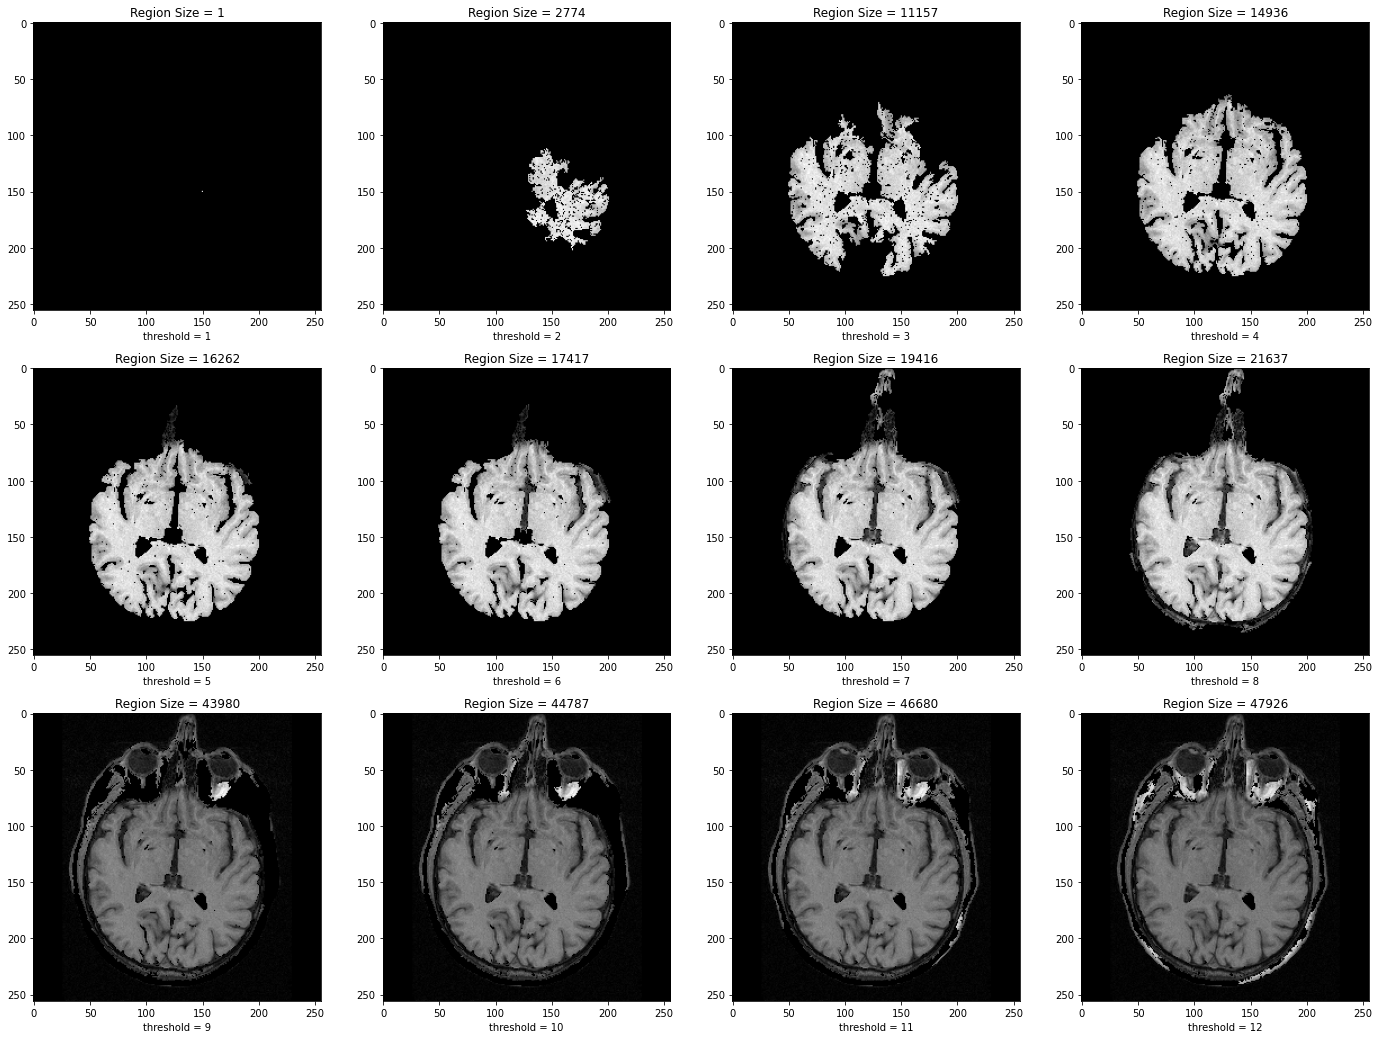

In [8]:
test_region_growing(starting_point, brain_im, 1)

When region growing is directly applied to the image, it either fails to include some of the pixels of the brain due to noise or includes parts that do not belong to brain.

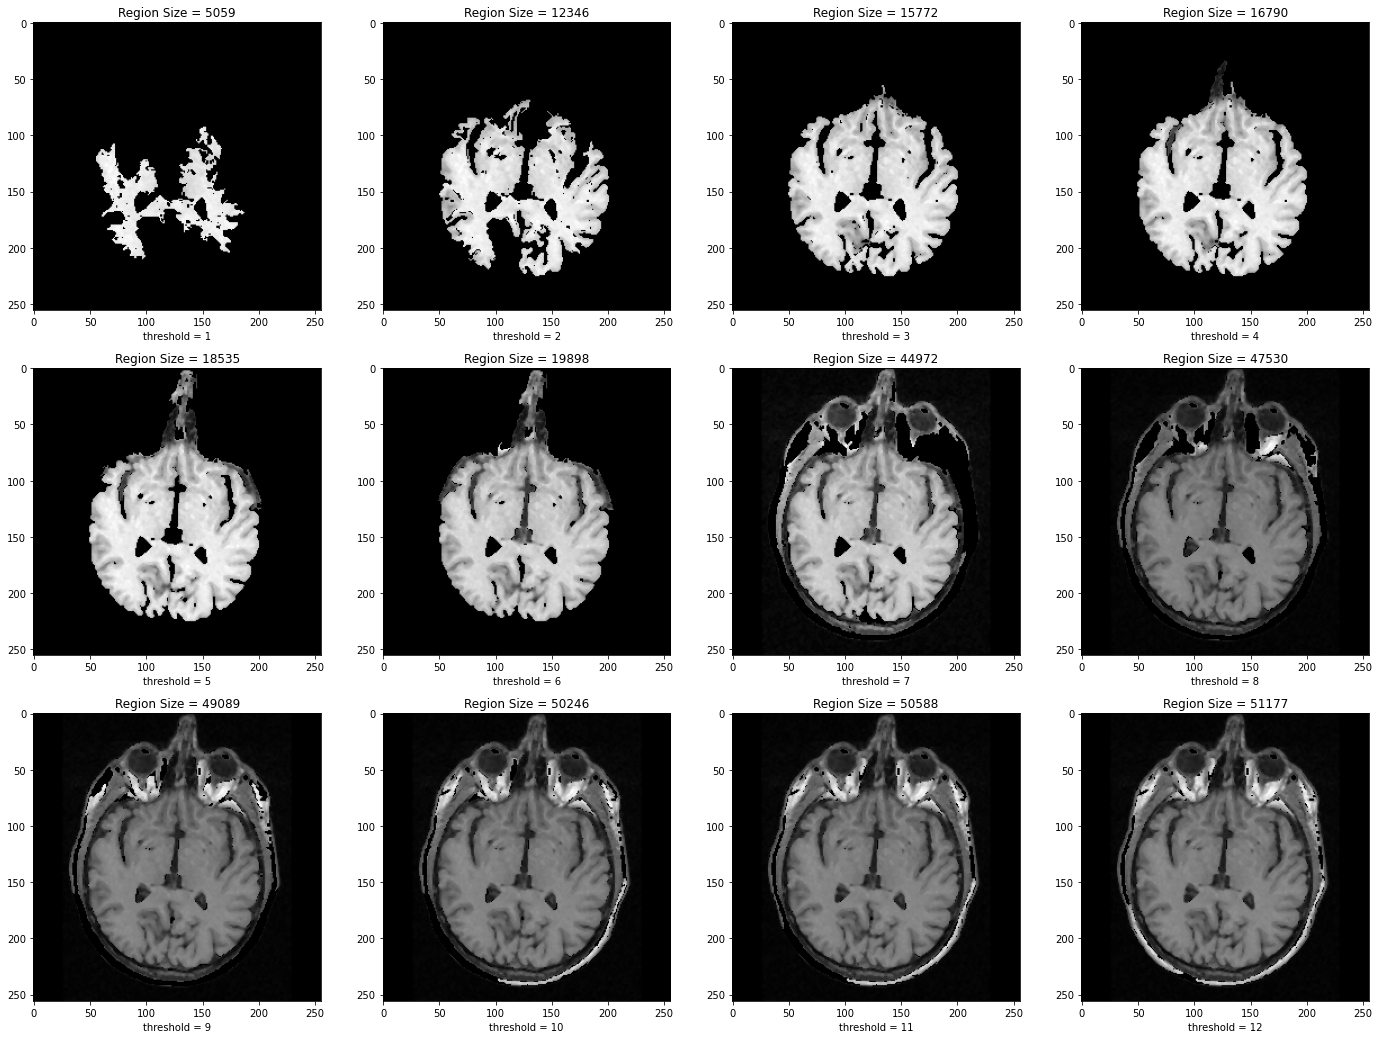

In [9]:
test_region_growing(starting_point, denoised_img, 1)

When median (low-pass) filter is applied quick jumps, oscillations, outliers etc. are eliminated. In other words, high frequency components are eliminated. This results in the region growing algorithm to jump over the skull, which is not desired.

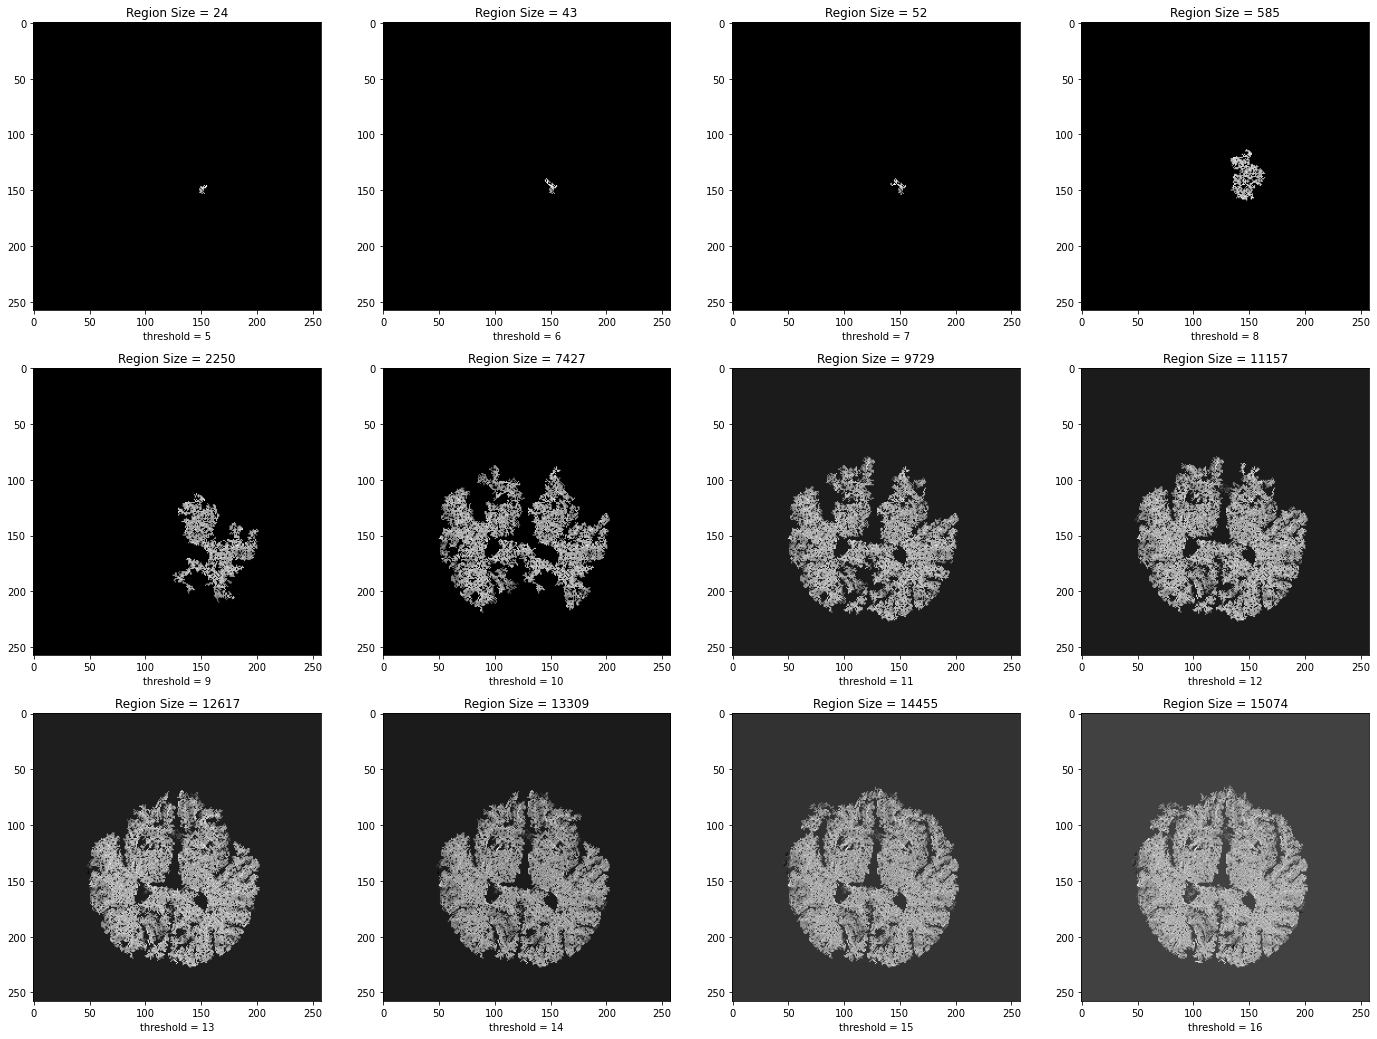

In [10]:
test_region_growing(starting_point, laplacian_filtered_img, 5)

When a HPF is applied, details and edges become sharper but HPF also amplifies the noise, which results in more holes in the chosen region.

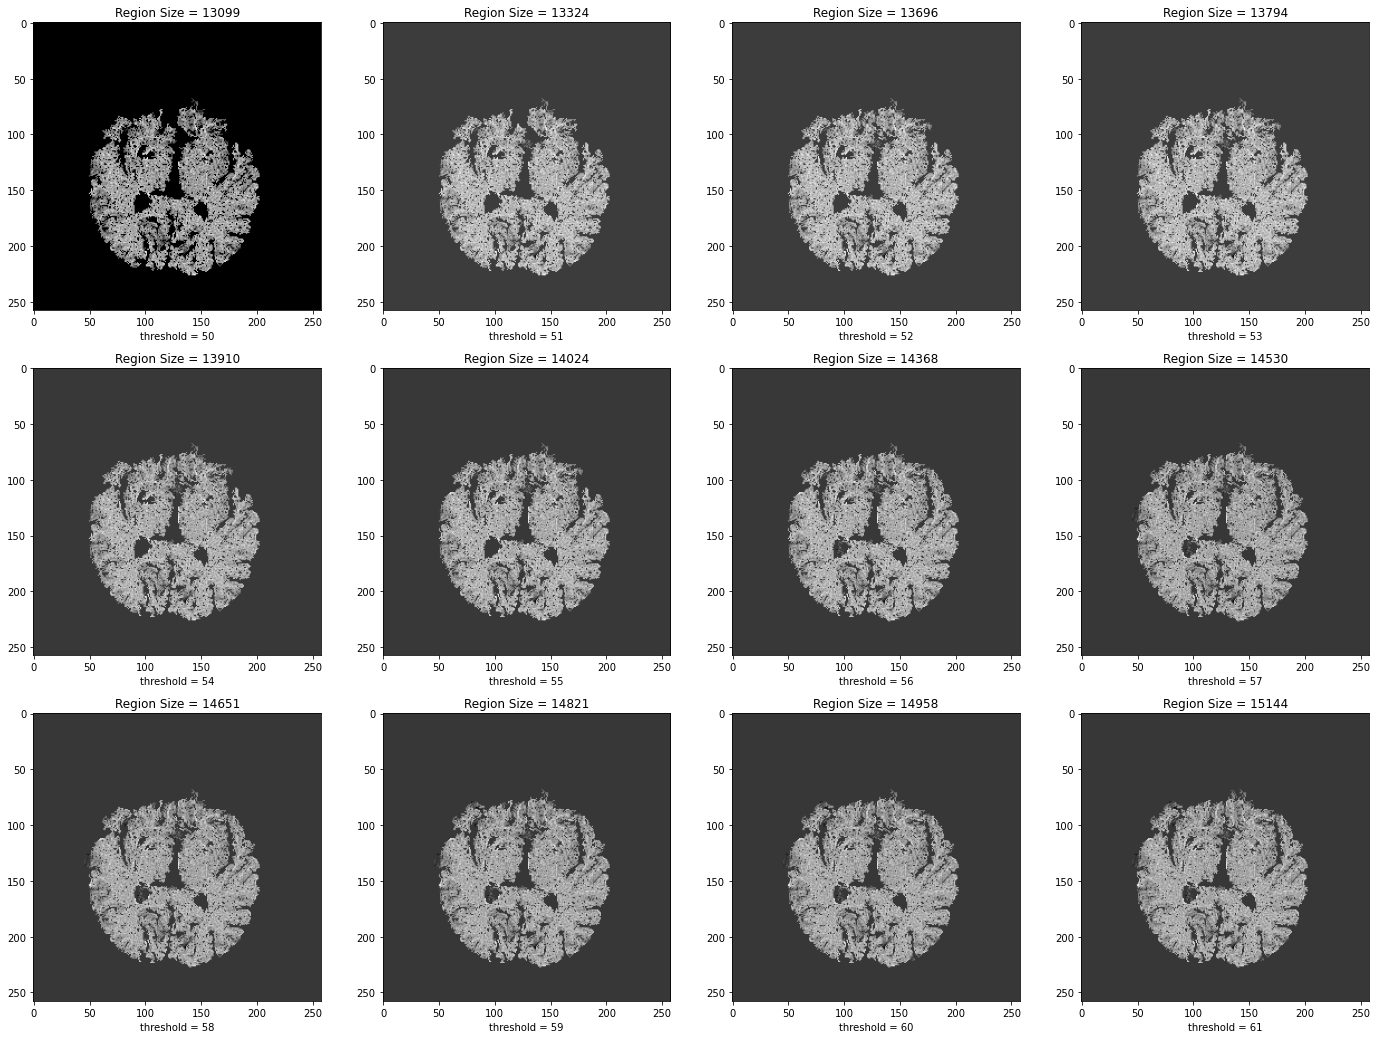

In [11]:
test_region_growing(starting_point, sharpened_img, 50)

With more aggressive HPF details are even more amplified but also the noise, which means that the actual size of the brain is greater than the calculated size due to noise.

Considering the results above, the most accurate image is obtained when the image is denoised with median filter and threshold is chosen as 3. As a result total area of the brain in pixels is found to be 15572.

### 1.3 Contour detection (5pts)

For brain segmantation with contour detection method, we first need to detect edges of the MRI image. Canny edge detection is chosen since it is more efficient and it removes noise from image by smoothening. Afterwards, morphological closing operation is applied to the resultant image to close gaps in the image, which will allow us to detect contours more properly in the next steps.

(<matplotlib.image.AxesImage at 0x7f930d78c460>,
 Text(0.5, 1.0, 'Closing Operation after Edge Detection'))

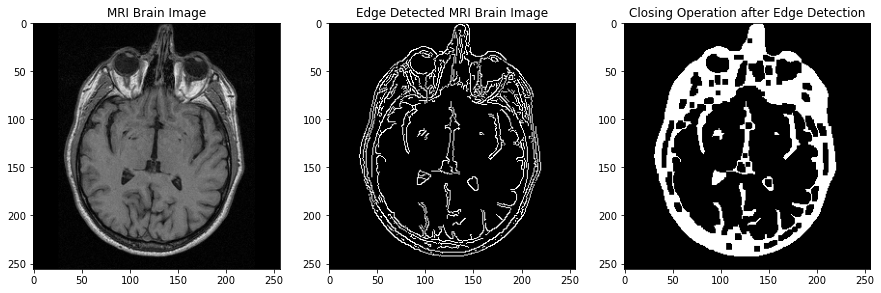

In [12]:
# Add your implementation and discussion
import numpy as np
import cv2 as cv 

contour = cv.Canny(brain_im, 90, 250)
kernel = np.ones((5,5), np.uint8)
closing = cv.morphologyEx(contour, cv.MORPH_CLOSE, kernel)

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(brain_im, cmap='gray'), ax[0].set_title('MRI Brain Image')
ax[1].imshow(contour, cmap='gray'), ax[1].set_title('Edge Detected MRI Brain Image')
ax[2].imshow(closing, cmap='gray'), ax[2].set_title('Closing Operation after Edge Detection')



Contours are drawn from the image ***closing*** with OpenCv functions **findContours** and **drawContours**.

(<matplotlib.image.AxesImage at 0x7f930bba9940>,
 Text(0.5, 1.0, 'MRI Brain Image Contours'))

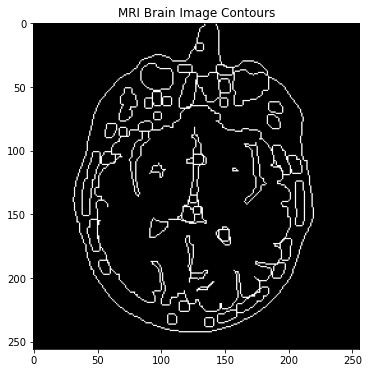

In [13]:
contours, hierarchy = cv.findContours(closing, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
drawing = np.zeros((closing.shape[0], closing.shape[1], 3), dtype=np.uint8)
cv.drawContours(drawing, contours, -1, (255,255,255) , 1)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(drawing), ax.set_title('MRI Brain Image Contours')

After obtaining contours, each contour area is calculated with OpenCv function **contourArea** and stored. It is observed that the contour with the largest area corresponds to the skull and the second biggest contour area corresponds to the brain. After sorting the areas and finding the contour index that corresponds to the brain, a mask for brain region is generated.

(<matplotlib.image.AxesImage at 0x7f930b9dac70>, Text(0.5, 1.0, 'Mask'))

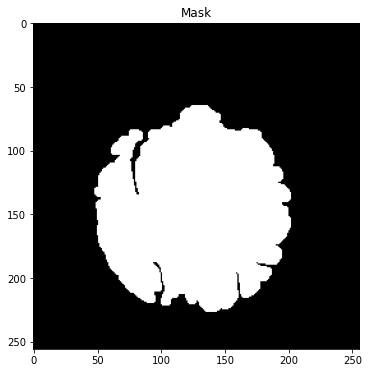

In [14]:
contour_areas = np.zeros([len(contours)])
contour_areas2 = np.zeros([len(contours)])
for i in range(len(contours)):
  contour_areas[i] = cv.contourArea(contours[i])

contour_areas2 = contour_areas.copy()
contour_areas2.sort()
index = np. where(contour_areas == contour_areas2[len(contours)-2])
mask = np.zeros((closing.shape[0], closing.shape[1]), dtype=np.uint8)

cv.drawContours(mask, [contours[index[0][0]]], -1, color=255, thickness=-1)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(mask, cmap='gray'), ax.set_title('Mask')

The brain region is segmented by using the mask coordinates where the mask pixel values are 255. The brain region size is found from **contourArea** function with index that corresponds to brain region contour. In the code below, ***contour_areas2*** corresponds to the sorted contour areas and the second biggest area value is the size of the brain region.

(<matplotlib.image.AxesImage at 0x7f930bba90a0>,
 Text(0.5, 1.0, 'Brain Segmentation: Region Size (pixels)=17841.0'))

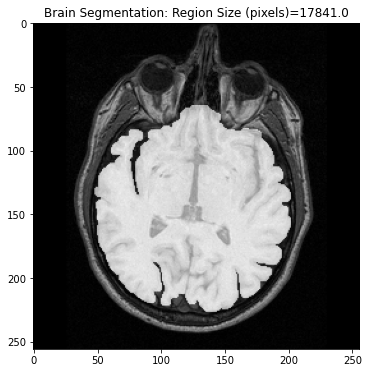

In [15]:
brain_img = cv.merge((brain_im, brain_im, brain_im))
brain_img[mask==255] = brain_img[mask==255] + [140,140,140]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_img, cmap='gray'), ax.set_title('Brain Segmentation' + ': Region Size (pixels)=' + str(contour_areas2[len(contours)-2]))        

*   Image segmentation with contour detection has lower computational complexity compared to region growing method.
*   Fine-tuning in lower and upper thresholds of Canny edge detector is necessary. Thresholding values without fine-tuning might result in images that are not segmented accurately, especially for low contrast image contents.

### 1.4 Additional method (5pts)

The chosen aditional method is K-means clustering. It separates the pixels of the image into K different clusters based on their values and replaces it by the mean of the cluster, making the image more homogenous and allowing for easy separation using tresholding. However, this method is best suited for images containing elements with distinct values and doesn't fare as well when undesirable elements have similar values as undesirable ones, as is the case here (Parts of the skull end up getting included in the cluster containing the brain). To circumvent this, some post-processing was applied to clean up the picture.

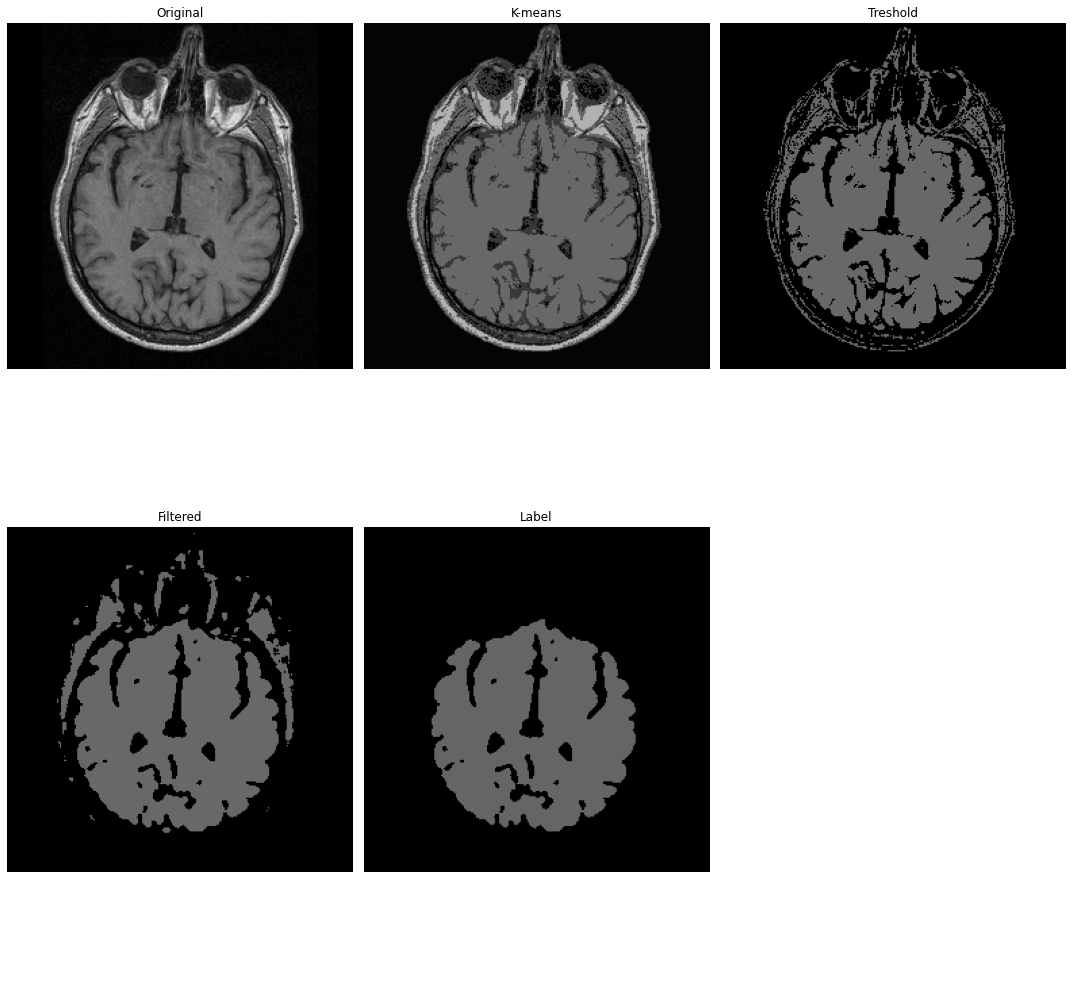

The detected region has a size of  15910  pixels


In [16]:
# Add your implementation and discussion

# Import necessary libraries
from sklearn import cluster
from skimage import data
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters
from skimage.measure import label


# Define useful functions

# Fuction that takes an array and the number of clusters as an input a executes K-means clustering on the values of the array
def km_clust(array, n_clusters):
    
    # Create a line array, the lazy way
    X = array.reshape((-1, 1))
    # Define the k-means clustering problem
    k_m = cluster.KMeans(n_clusters=n_clusters, n_init=3)
    # Solve the k-means clustering problem
    k_m.fit(X)

    # Get the coordinates of the clusters centres as a 1D array
    values = k_m.cluster_centers_.squeeze()

    # Get the label of each point
    labels = k_m.labels_

    return(values, labels)


# Function to find the second most recuring value in an array (used to detect the brain region)
def find_second_most_common(array):

  detect = np.bincount(array.flatten())
  detect[detect.argmax()] = 0

  return detect.argmax()


# Parameters (to be tweaked depending on the image)
n_clusters = 4            # Number of clusters for K-means culstering. The more there are, the less homogenous the grayscale values in the outputted image will be.
epsilon = 5               # Tresholding value. When tresholding, we keep all pixels that have a value included in an interval [-epsilon;+epsilon] centered around the value of the pixels of the brain.
background_value = 0      # The grayscale value of the background. Set to 0 for black.
brain_value = 75          # The grayscale value of the brain. Set to 75 for gray.


# Read the data
image = brain_im

# Group similar grey levels using the amount of clusters set previously
values, labels = km_clust(image, n_clusters)

# Create the segmented array from labels and values
cluster_image = np.choose(labels, values)
# Reshape the array as the original image
cluster_image.shape = image.shape

# Set pixels with values under or over a certain treshold (centered around the value of the brain pixels) to the value of the background
treshold_image = np.choose(labels, values)
treshold_image.shape = image.shape
color_threshold = find_second_most_common(treshold_image.astype(int))
treshold_image[treshold_image < color_threshold-epsilon] = background_value
treshold_image[treshold_image > color_threshold+epsilon] = background_value

# Apply a filter to separate the brain from the small residues left after clustering as well as generalise the shape
filter_image = filters.median(treshold_image, selem=np.ones((5, 5)))

# Remove the small residues that are separate from the brain
label_image,label_num = label(filter_image, background=None, return_num=True, connectivity=None)
brain_label = find_second_most_common(label_image)
label_image[label_image != brain_label] = background_value
label_image[label_image == brain_label] = brain_value

# Counts the numbers of pixels with the value as the one set for the brain
count_arr = np.bincount(label_image.flatten())
size_of_detected_region = count_arr[brain_value]

# Get the values of min and max intensity in the original image
vmin = image.min()
vmax = image.max()

# display results
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15), sharex=True, sharey=True, subplot_kw={'adjustable':'box'})
ax = axes.ravel()

ax[0].imshow(image,cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
ax[0].set_title("Original")

ax[1].imshow(cluster_image,cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
ax[1].set_title("K-means")

ax[2].imshow(treshold_image,cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
ax[2].set_title("Treshold")

ax[3].imshow(filter_image,cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
ax[3].set_title("Filtered")

ax[4].imshow(label_image,cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
ax[4].set_title("Label")


for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()


print('The detected region has a size of ',size_of_detected_region,' pixels')

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different
colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity
normalization should probably be used.

hint: RGB color space might not be optimal. Consider using HSV or LAB color space.

### 2.1 Visualization

In [1]:
#Load Modules
from skimage.color import rgb2hsv, rgb2gray, gray2rgb
import numpy as np
from scipy import ndimage
from skimage import feature
from skimage.color import label2rgb
from skimage.measure import label, regionprops, regionprops_table

# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

NameError: name 'os' is not defined

In [ ]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts) 
To find the number of shapes of each color, center coordinates of the objects are found after applying edge detection. For each object, region growing method is then applied. To compare colors of the objects, images are converted to LAB image space from RGB. The distance between each pixel in the 3-D Lab space is used as the metric for constructing regions.

### 2.3 Total area (in pixels) of each color (5 pts)
By applying region growing for every pixel, number of pixels for each region is calculated. 

First, images are converted to grayscale before performing edge detection.

In [ ]:
images_gray = rgb2gray(images)
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images_gray, im_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
plt.show()

Edges of objects are obtained using Canny edge detector.

In [ ]:
first_im_gray =images_gray[0,:,:]
edges = feature.canny(first_im_gray, sigma=3)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(edges, cmap='gray'), ax.set_title('Edges of Objects')

To fill in the detected contours, **ndimage.binary_fill_holes** function is used. The binary image is obtained which illustrates the areas where the objects lie. 

In [ ]:
x = ndimage.binary_fill_holes(edges).astype(int)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(x, cmap='gray')

The binary image is labeled according to the connected regions. Afterwards, the properties of labeled image regions are obtained with the function **regionprops**. 10 different regions are found in the image, which correspond to the objects. The geometric center coordinates are found for each region in the function **routine**

In [2]:
label_image = label(x)
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(label_image)

props = regionprops(label_image)
y_coor = np.zeros(len(props))
x_coor = np.zeros(len(props))
    
for i in range(len(props)):
    x_coor[i], y_coor[i] = props[i].centroid
  
x_coor, y_coor = x_coor.astype(int), y_coor.astype(int)
coor = [tuple(x) for x in zip(x_coor, y_coor)]

NameError: name 'x' is not defined

To display the LAB images properly, pixel values are scaled so that they in between 0 and 1.

In [3]:
def scale_lab(lab_img):
    return (lab_img + np.array([0, 128, 128])) / np.array([100, 255, 255])

lab_images = np.array([skimage.color.rgb2lab(img) for img in images])

_, axes = plt.subplots(1, 3, figsize=(12,8))
for ax, img, im_name in zip(axes.ravel(), lab_images, im_names):
    ax.imshow(scale_lab(img))
    ax.set_title(im_name)

NameError: name 'images' is not defined

By equalizing the black-white ratio axis values for each pixel, taking the black-white intensity value of arena-shapes-03 as the reference, illumination level of each image is balanced.

In [4]:
ref = (np.amax(lab_images[2,:,:,0]))
ratio1 = ref / np.amax(lab_images[0,:,:,0])

lab_images[0,:,:,0] = lab_images[0,:,:,0]*ratio1
lab_images[1,:,:,0] = lab_images[0,:,:,0]  
lab_images[2,:,:,0] = lab_images[0,:,:,0]

fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), lab_images, im_names):
    ax.imshow(scale_lab(im))
    ax.axis('off')
    ax.set_title(nm)
plt.show()

NameError: name 'lab_images' is not defined

With use of following functions, the routine function receives original images, performs the pre-image processing steps explained above and then prints the number of shapes for each color, total number of pixels for each color and as well as displaying all the detected shapes on by one.

In [25]:
def analyze_objects(objects, threshold, coordinates):
    
    """
        given the threshold, center coordinates of the shapes, and the images including detected shapes, 
        this function returns a dictionary where each key is a distinct color and the values of each key is 
        a list of objects with same color.
    """
    
    objects[0].coor = tuple(coordinates[0])
    
    # First color-object pair for comparison
    color_object_dict = {'color_1':[objects[0]]}
    
    num_of_colors_found = 1
    
    for i in range(1, len(objects)):
        # get the coordinate of the current object
        objects[i].coor = coordinates[i]
        
        # flag for new color
        new_color_found = True
        
        for color in color_object_dict:
            # take a sample shape for each color to use in comparison
            sample_region = color_object_dict[color][0]
            
            #compare the distance between the current shape's color with a sample colors found so far
            if np.sum(np.square((objects[i].region[objects[i].coor] - sample_region.region[sample_region.coor]))) < threshold: 
                color_object_dict[color].append(objects[i])
                new_color_found = False
        # if a new color is found add it to the color dictionary.        
        if new_color_found:  
            num_of_colors_found += 1
            color_object_dict['color_' + str(num_of_colors_found)] = [objects[i]]
                
    return color_object_dict


def plot_images_of_same_color(color_obj_dict):
    """
        given the dictionary returned by analyze_objects function, plots the detected shapes and their colors.
    """
    for color in color_obj_dict:
        _, ax = plt.subplots(1, len(color_obj_dict[color]), figsize=((15, 15 * len(color_obj_dict[color]))))
        
        for i in range(len(color_obj_dict[color])):
            if len(color_obj_dict[color]) > 1:
                ax[i].imshow(color_obj_dict[color][i].region)
                ax[i].set_title((f"Object {i + 1} of {color}"))
            else:
                ax.imshow(color_obj_dict[color][i].region)
                ax.set_title((f"Object {i + 1} of {color}"))
                
def count_objects(color_obj_dict):
    """
        Counts the number of shapes in the dictionary returned by analyze_objects
    """
    count = 0
    
    for key in color_obj_dict:
        count += len(color_obj_dict[key])
    return count
        
        
def find_threshold_2(analyze_obj, start, end, regions, count_objects, coor):
    """
        This function performs binary search to find the optimum threshold for seperating different colors
        in 3-D LAB image space.
    """
    mid = start
    num_objects = len(regions)
    
    while (end - start >= 0.0000000001) or not (end - start <= 0.000001 and num_objects == num_obj):
        mid = (end + start) / 2        
        colors_objects = analyze_objects(regions, mid, coor)
        num_obj = count_objects(colors_objects)
    
        if num_obj > num_objects:
            end = mid - 0.0000000001
        else:
            start = mid + 0.0000000001
            
    return mid

def find_regions(coor, img, scale_lab):
    """
        Applied region growing to the shapes whose coordinates are known and returns a list of regions 
        for each object whose center coordinates are known.
    """
    regions = []

    for x, y in coor:
        new_region = region_growing(scale_lab(img))
        new_region.grow_region_lab(x, y, 0.020)
        regions.append(new_region)
    
    return regions

In [26]:
def routine(images, scale_lab, find_regions, threshold, count_objects,
            analyze_objects, plot_images_of_same_color):
    
    """
        This function incorporates the pre-image processings steps described above and then prints and plots
        the number of shapes and number of pixels for each color.
    """
    
    # pre-image processing steps described and visualized above.
    images_gray = rgb2gray(images)
    first_im_gray =images_gray[0,:,:]
    edges = feature.canny(first_im_gray, sigma=3)
    x = ndimage.binary_fill_holes(edges).astype(int)
    label_image = label(x)
    
    props = regionprops(label_image)
    y_coor = np.zeros(len(props))
    x_coor = np.zeros(len(props))
    
    for i in range(len(props)):
        x_coor[i], y_coor[i] = props[i].centroid
  
    x_coor, y_coor = x_coor.astype(int), y_coor.astype(int)
    coor = [tuple(x) for x in zip(x_coor, y_coor)]
    
    lab_images = np.array([skimage.color.rgb2lab(img) for img in images])
    
    ref = (np.amax(lab_images[2,:,:,0]))
    ratio1 = ref / np.amax(lab_images[0,:,:,0])

    lab_images[0,:,:,0] = lab_images[0,:,:,0]*ratio1
    lab_images[1,:,:,0] = lab_images[0,:,:,0]  
    lab_images[2,:,:,0] = lab_images[0,:,:,0]
    
    
    for i in range(len(lab_images)):
        # plot the original image
        plt.figure(figsize=(15, 15))
        skimage.io.imshow(images[i])
        plt.title('Image' + str(i + 1))
        
        # extract regions from the current image
        regions = find_regions(coor, lab_images[i], scale_lab)
        
        # find the optimal threshold with binary search
        thr = find_threshold_2(analyze_objects, *threshold, regions, count_objects, coor)
        
        # seperate objects according to their colors.
        colors_objects = analyze_objects(regions, thr, coor)
        print("**********************************************************")
        print(f"* There are {len(colors_objects)} different colors in image", i + 1, '\n')
        
        # calculate the number of pixels for each color
        for color in colors_objects:
            total_area = 0
            for obj in colors_objects[color]:
                total_area += obj.size
        
            print(f"There are {len(colors_objects[color])} objects of {color}\n---> Total pixel for {color} is {total_area}")
        plot_images_of_same_color(colors_objects)
        print('***********************************************************\n\n\n\n')
        

**********************************************************
* There are 2 different colors in image 1 

There are 5 objects of color_1
---> Total pixel for color_1 is 3710
There are 5 objects of color_2
---> Total pixel for color_2 is 3438
***********************************************************




**********************************************************
* There are 2 different colors in image 2 

There are 5 objects of color_1
---> Total pixel for color_1 is 3451
There are 5 objects of color_2
---> Total pixel for color_2 is 3386
***********************************************************




**********************************************************
* There are 2 different colors in image 3 

There are 5 objects of color_1
---> Total pixel for color_1 is 3939
There are 5 objects of color_2
---> Total pixel for color_2 is 3444
***********************************************************






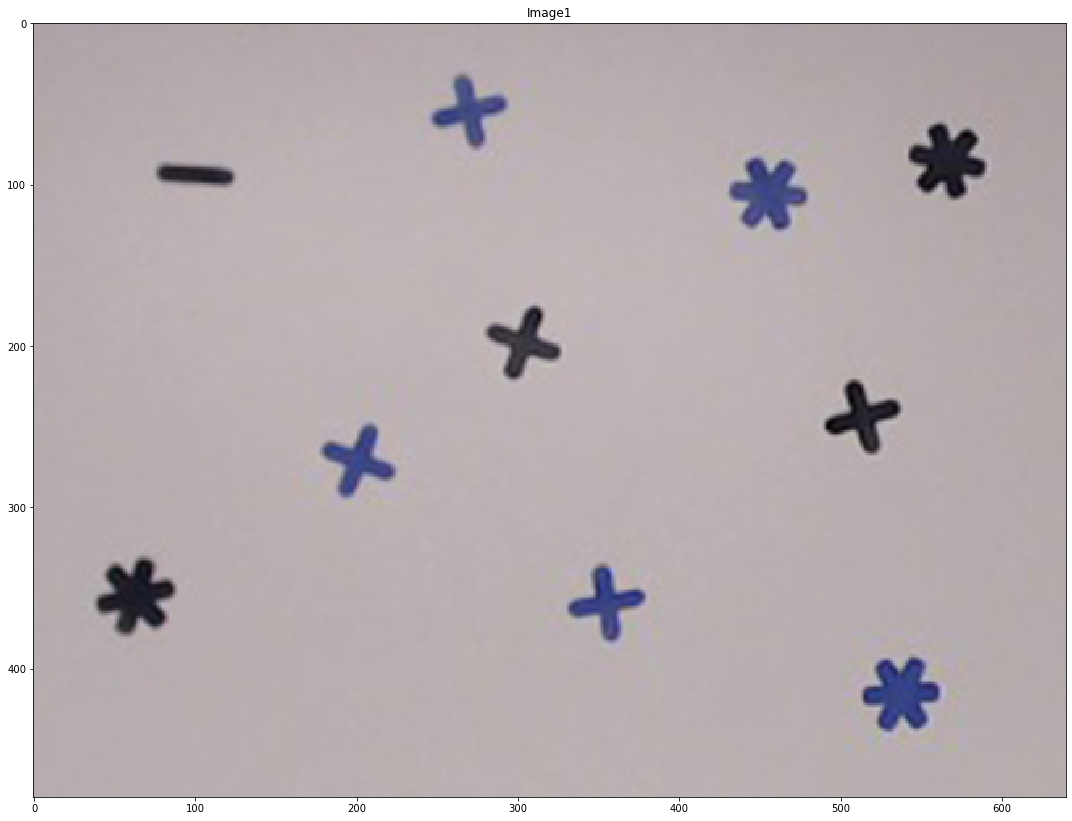

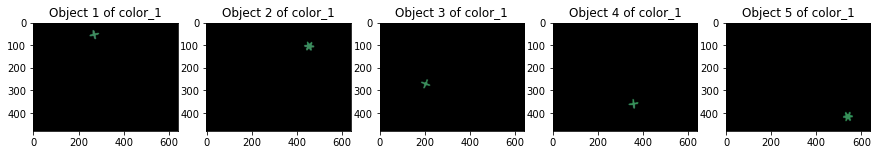

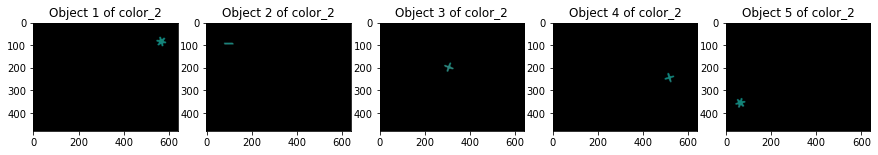

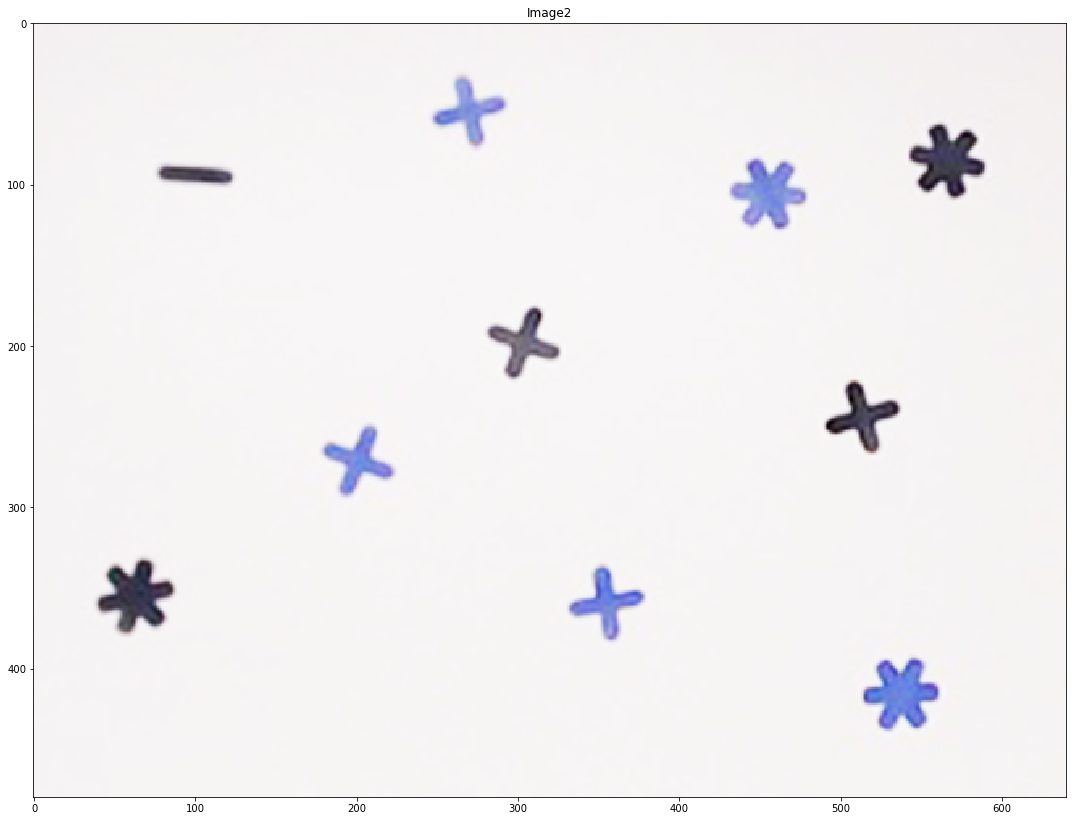

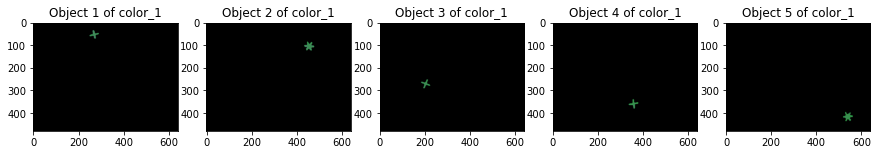

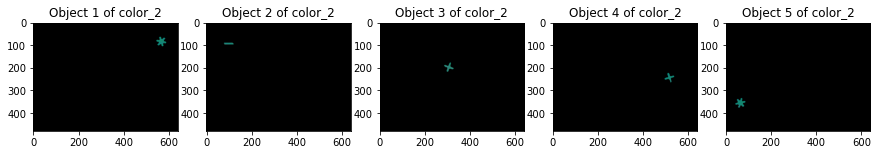

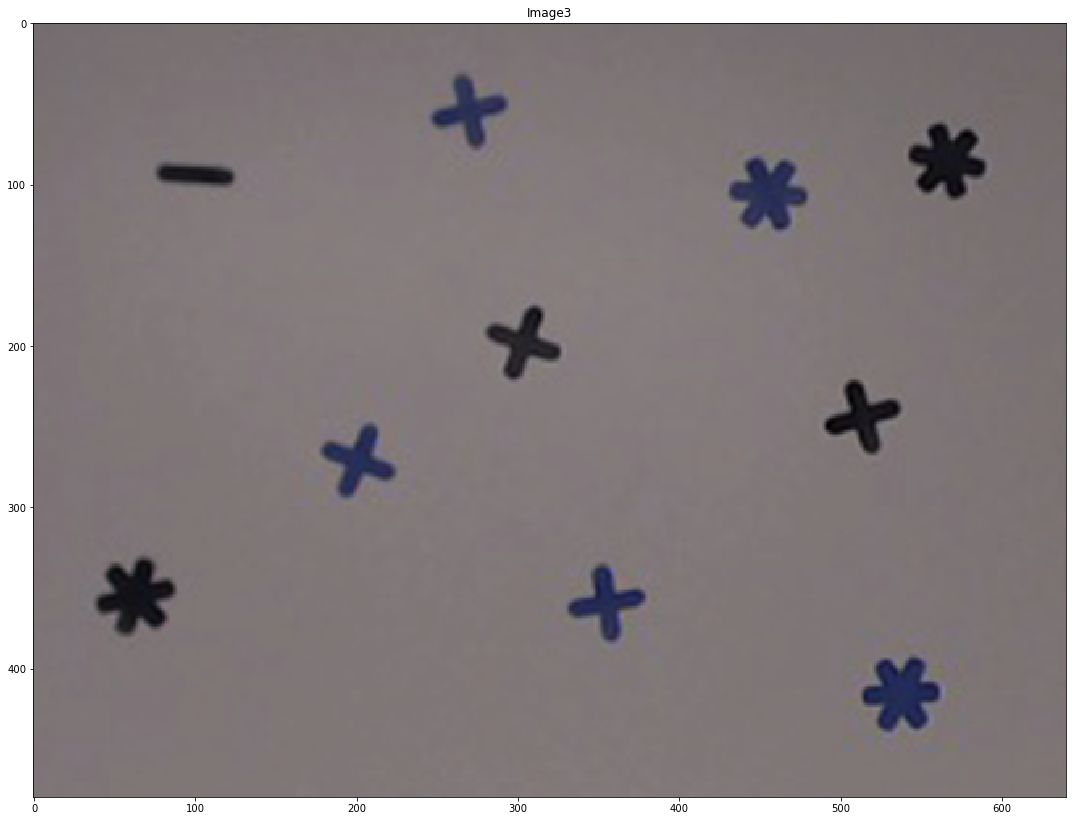

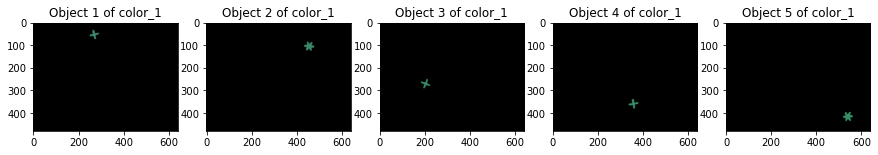

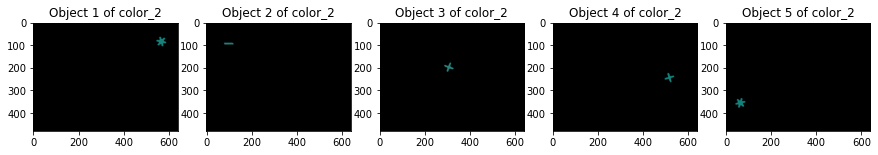

In [27]:
# Start and end points for binary search
min_threshold = 0.006
max_threshold = 0.040

threshold = (min_threshold, max_threshold)

routine(images, scale_lab, find_regions, threshold, count_objects,
        analyze_objects, plot_images_of_same_color)